In [4]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [21]:
import os
import cv2
import time
import optuna
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix

from utils.data import compute_sentinel1_indices, compute_sentinel2_indices, load_pickled_ds


In [2]:
def confussion_matrix(y_val, y_pred):

    counts = np.unique(y_val, return_counts=True)[1]
    class_ratios = np.round(counts / counts.sum(), 3)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    
    cm = confusion_matrix(y_val, y_pred)
    
    ratio_and_names = np.char.add(class_ratios.astype(str), np.char.add(' ', ds_classes))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ds_classes, yticklabels=ratio_and_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
ds_classes = ['Abies',
              'Acer',
              'Alnus',
              'Betula',
              'Cleared',
              'Fagus',
              'Fraxinus',
              'Larix',
              'Picea',
              'Pinus',
              'Populus',
              'Prunus',
              'Pseudotsuga',
              'Quercus',
              'Tilia']

class_imbal_weights = [1002, 2517, 2598, 2675, 4362, 8482, 2301, 3706, 8475, 8822, 391, 301, 3406, 9344, 188]

len(class_imbal_weights) == len(ds_classes)

True

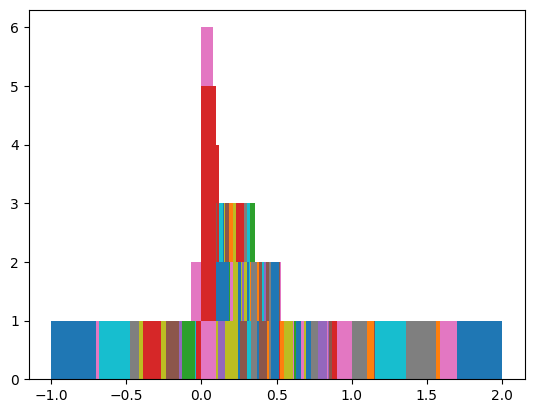

In [5]:

for u in un_distros:
    plt.hist(u)

plt.show()

In [4]:
X_train_s1, y_train_s1, full_distrib_train_s1, X_val_s1, y_val_s1, full_distrib_val_s1 = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s1_60.pkl')
X_train_s2, y_train_s2, full_distrib_train_s2, X_val_s2, y_val_s2, full_distrib_val_s2 = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s2_60.pkl')

channel_order_s2 = ["B02", "B03", "B04", "B08", "B05", "B06", "B07", "B08A", "B11", "B12", "B01", "B09"]
channel_order_s1 = ["VV", "VH", "VV-VH"]

s2_datasets_descriptions = {
    "s2_raw": channel_order_s2,
    "s2_only_veg_indexes": {"NDVI", "EVI", "NDWI", "GNDVI", "SAVI", "ARVI", "MSAVI"},
    "s2_plus_ndvi_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI"},
    "s2_plus_ndvi_evi_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI", "EVI"},
    "s2_plus_ndvi_evi_ndwi_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI", "EVI", "NDWI"},
    "s2_plus_all_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI", "EVI", "NDWI", "GNDVI", "SAVI", "ARVI", "MSAVI"}
}

s1_datasets_descriptions = {
    "s1_raw": channel_order_s1,
    "s1_plus_rvi": {"VV", "VH", "VV-VH", "RVI"},
    "s1_plus_rvi_ndpi": {"VV", "VH", "VV-VH", "RVI", "NDPI"},
    "s1_plus_rvi_ndpi_csi": {"VV", "VH", "VV-VH", "RVI", "NDPI", "CSI"},
    "s1_plus_rvi_ndpi_csi_vsi": {"VV", "VH", "VV-VH", "RVI", "NDPI", "CSI", "VSI"}
}

In [21]:
np.all(y_val_s2 == y_val_s1) and np.all(y_train_s2 == y_train_s1) 

True

In [22]:
def transform_data(X_train, y_train, X_val, y_val, slicer_func, requested_indices, channel_order):
    
    
    X_train_ = slicer_func(X_train, requested_indices, channel_order)
    X_val_ = slicer_func(X_val, requested_indices, channel_order)

    X_train_ = (X_train_ - X_train_.mean(axis=(0,2,3), keepdims=True)) / (X_train_.std(axis=(0,2,3), keepdims=True) + 1e-8)
    X_val_ = (X_val_ - X_val_.mean(axis=(0,2,3), keepdims=True)) / (X_val_.std(axis=(0,2,3), keepdims=True) + 1e-8)

    X_val_ = X_val_.reshape(X_val_.shape[0], -1)
    X_train_ = X_train_.reshape(X_train_.shape[0], -1)

    # actually incorrect normalization. we must norm by channels statistics before reshape
    # sc = StandardScaler()
    # X_train_ = sc.fit_transform(X_train_)
    # X_val_ = sc.transform(X_val_)

    
    return X_train_, y_train, X_val_, y_val

Text(0.5, 1.0, 'Val_distro')

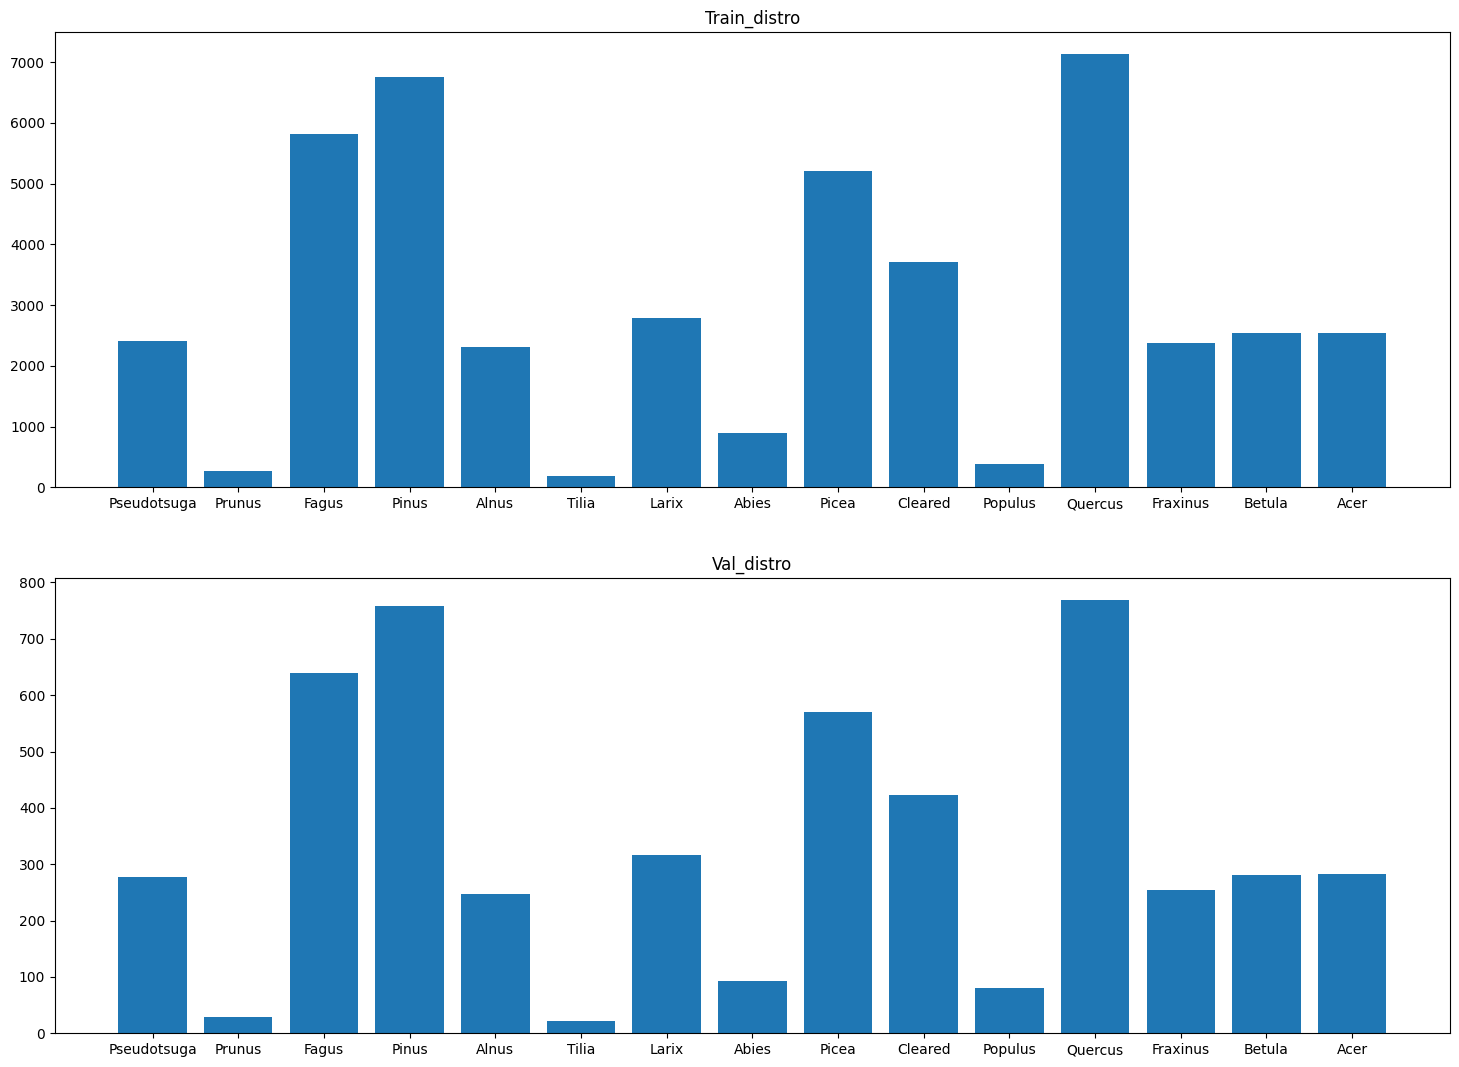

In [23]:

class_names = os.listdir('data/ims/sorted/s1_60m/train/')

class_counts_train = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/train/', class_name))) for class_name in class_names]
class_counts_val = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/test/', class_name))) for class_name in class_names]

f, ax = plt.subplots(2, 1, figsize=(18, 13))

ax[0].bar(class_names, class_counts_train)
ax[0].set_title('Train_distro')

ax[1].bar(class_names, class_counts_val)
ax[1].set_title('Val_distro')

Just bcs of curiosity let's see how different species look like. With naked eye it's not possible to classify anything here.

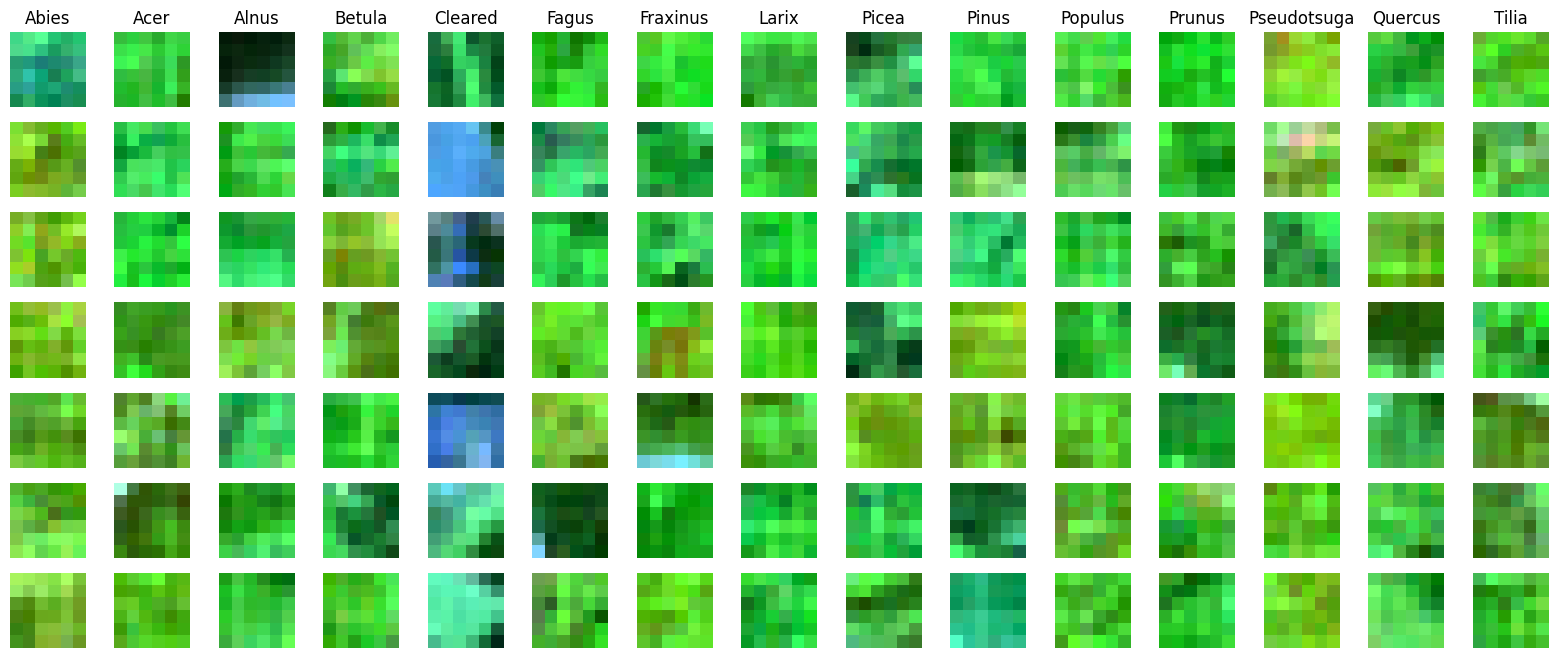

In [24]:
def vis_data(n_samples: int, y, x, channels):
    f, ax = plt.subplots(n_samples, len(ds_classes), figsize=(20, 8))
    # x = (x - x.mean(axis=(1), keepdims=True)) / (x - x.std(axis=(1), keepdims=True))
    idxes = {num: np.random.choice(np.where(y == num)[0], n_samples, replace=False) 
             for num in range(len(ds_classes)) if np.sum(y == num) >= n_samples}
    
    for i, indices in idxes.items():

        for j, idx in enumerate(indices):

            im = x[idx, [0,1,2], :, :]
            im = cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX)
            im = np.transpose(im, (1, 2, 0))
            im = np.uint8(im)[:, :, :]

            ax[j, i].imshow(im)
            ax[j, i].axis('off') 

            if not j:
                ax[j, i].set_title(ds_classes[i])

    plt.show() 
%clear
vis_data(7, y_train_s1, X_train_s2, [0, 1, 2])

In [25]:
all_datasets = {}
for name, req_indices in s2_datasets_descriptions.items():
    all_datasets[name] = transform_data(X_train_s2, y_train_s2, X_val_s2, y_val_s2, compute_sentinel2_indices, req_indices, channel_order_s2)

for name, req_indices in s1_datasets_descriptions.items():
    all_datasets[name] = transform_data(X_train_s1, y_train_s1, X_val_s1, y_val_s1, compute_sentinel1_indices, req_indices, channel_order_s1)


all_datasets['raw_s1+raw_s2'] = (np.hstack((all_datasets['s1_raw'][0], all_datasets['s2_raw'][0])), y_train_s1,
                                 np.hstack((all_datasets['s1_raw'][2], all_datasets['s2_raw'][2])), y_val_s1)

all_datasets['all_s1+all_s2'] = (np.hstack((all_datasets['s1_plus_rvi_ndpi_csi_vsi'][0], all_datasets['s2_plus_all_indexes'][0])), y_train_s1, 
                                 np.hstack((all_datasets['s1_plus_rvi_ndpi_csi_vsi'][2], all_datasets['s2_plus_all_indexes'][2])), y_val_s1)

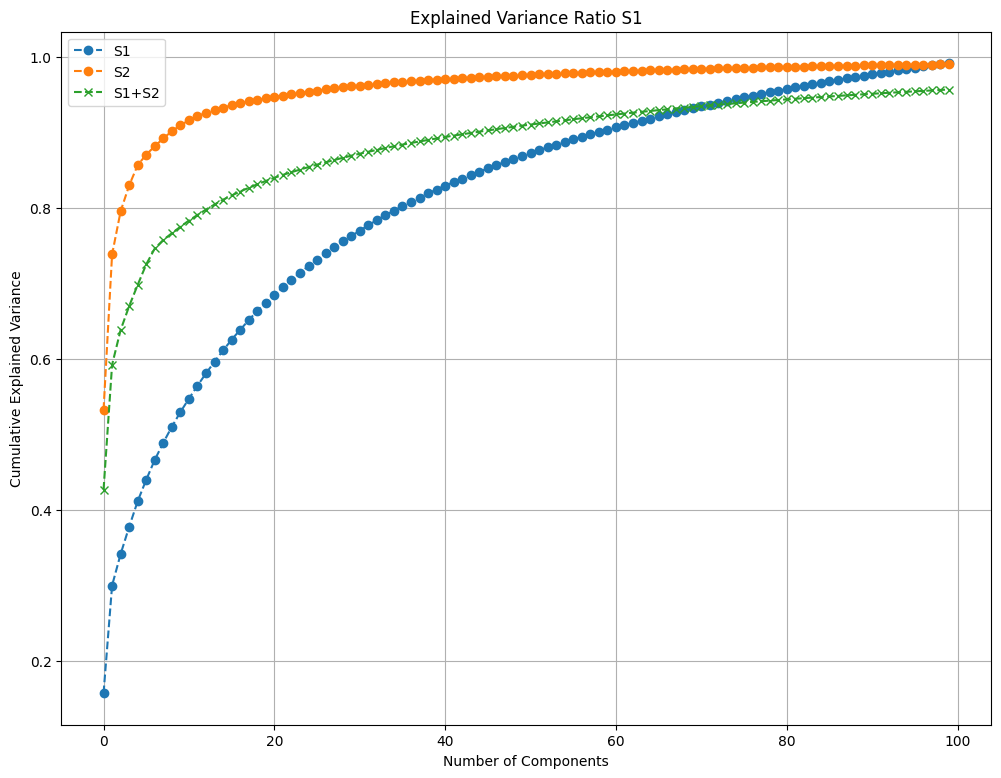

In [25]:
pca_s1 = PCA(n_components=100, svd_solver='full')
pca_s1.fit(all_datasets["s1_raw"][0])

pca_s2 = PCA(n_components=100, svd_solver='full')
pca_s2.fit(all_datasets["s2_raw"][0])

pca_s1s2 = PCA(n_components=100, svd_solver='full')
pca_s1s2.fit(all_datasets["raw_s1+raw_s2"][0])

plt.figure(figsize=(12, 9))
plt.plot(np.cumsum(pca_s1.explained_variance_ratio_), marker='o', linestyle='--', label='S1')
plt.plot(np.cumsum(pca_s2.explained_variance_ratio_), marker='o', linestyle='--', label='S2')
plt.plot(np.cumsum(pca_s1s2.explained_variance_ratio_), marker='x', linestyle='--', label='S1+S2')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio S1')
plt.legend()
plt.grid()

Curiosity time 2: Let's see how samples are distributed in space of the PC1, PC2 and PC3:

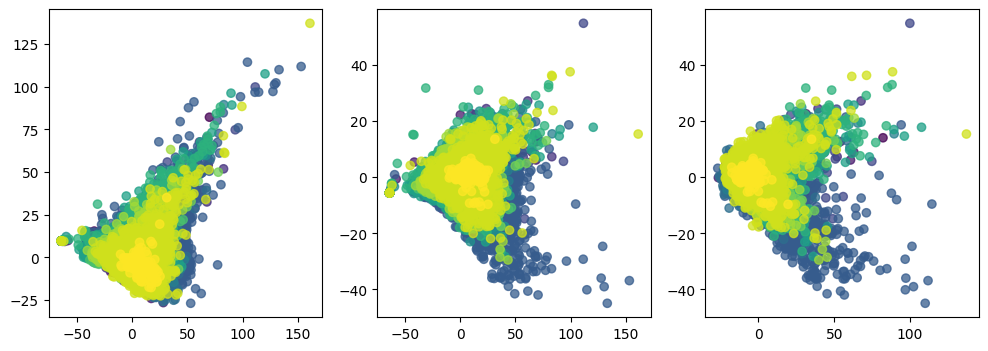

In [26]:
pcaed_s2 = pca_s2.transform(all_datasets["s2_raw"][0])[:, :3]

f, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(pcaed_s2[:, 0], pcaed_s2[:, 1], c=y_train_s2, alpha=0.75)
ax[1].scatter(pcaed_s2[:, 0], pcaed_s2[:, 2], c=y_train_s2, alpha=0.75)
ax[2].scatter(pcaed_s2[:, 1], pcaed_s2[:, 2], c=y_train_s2, alpha=0.75)

# ax.scatter(pcaed_s2[:, 0], pcaed_s2[:, 1], pcaed_s2[:, 2], c=y_train_s2, alpha=0.75)
%clear

This doesn't look like something usefull: classes are not realy separated. 

In [27]:
pca_s1_40 = PCA(n_components=35, svd_solver='full')
pca_s1_40.fit(all_datasets["s1_raw"][0])
X_train_s1_pca = pca_s1_40.transform(all_datasets["s1_raw"][0])
X_val_s1_pca = pca_s1_40.transform(all_datasets["s1_raw"][2])


pca_s2_15 = PCA(n_components=15, svd_solver='full')
pca_s2_15.fit(all_datasets["s2_raw"][0])
X_train_s2_pca = pca_s2_15.transform(all_datasets["s2_raw"][0])
X_val_s2_pca = pca_s2_15.transform(all_datasets["s2_raw"][2])


all_datasets['s1_pca'] = (X_train_s1_pca, y_train_s1, X_val_s1_pca, y_val_s1)
all_datasets['s2_pca'] = (X_train_s2_pca, y_train_s2, X_val_s2_pca, y_val_s2)

Here we tried classical SVM. But: the dataset has 50k samples and 20 or 40 features. Roughly speaking SVM has O(N^2) complexity. Moreever sklearn computes it on one core, so classical SVM seems not working. At the same time, SVM problem solved with SGD works, see below.

In [30]:
algos = {
    "svm_l1": SGDClassifier(loss='hinge', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "svm_l2": SGDClassifier(loss='hinge', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "linreg_l1": SGDClassifier(loss='log_loss', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "linreg_l2": SGDClassifier(loss='log_loss', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "perceptron_l1": SGDClassifier(loss='perceptron', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "perceptron_l2": SGDClassifier(loss='perceptron', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "squared_hinge_l1": SGDClassifier(loss='squared_hinge', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=7000, random_state=42, n_jobs=-1),
    "squared_hinge_l2": SGDClassifier(loss='squared_hinge', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=7000, random_state=42, n_jobs=-1),

    "catboost": CatBoostClassifier(
                    iterations=500,       
                    learning_rate=0.01,   
                    depth=6,              
                    verbose=50,           
                    random_seed=42,       
                    task_type='GPU'
                    ) 
}

In [31]:
for ds_name, data in all_datasets.items():
    print(ds_name, end=' ')
    for d in data:
        print(d.shape, end=' ')
    print()

s2_raw (45337, 432) (45337,) (5044, 432) (5044,) 
s2_only_veg_indexes (45337, 252) (45337,) (5044, 252) (5044,) 
s2_plus_ndvi_indexes (45337, 432) (45337,) (5044, 432) (5044,) 
s2_plus_ndvi_evi_indexes (45337, 468) (45337,) (5044, 468) (5044,) 
s2_plus_ndvi_evi_ndwi_indexes (45337, 504) (45337,) (5044, 504) (5044,) 
s2_plus_all_indexes (45337, 648) (45337,) (5044, 648) (5044,) 
s1_raw (45337, 108) (45337,) (5044, 108) (5044,) 
s1_plus_rvi (45337, 144) (45337,) (5044, 144) (5044,) 
s1_plus_rvi_ndpi (45337, 180) (45337,) (5044, 180) (5044,) 
s1_plus_rvi_ndpi_csi (45337, 216) (45337,) (5044, 216) (5044,) 
s1_plus_rvi_ndpi_csi_vsi (45337, 252) (45337,) (5044, 252) (5044,) 
raw_s1+raw_s2 (45337, 540) (45337,) (5044, 540) (5044,) 
all_s1+all_s2 (45337, 900) (45337,) (5044, 900) (5044,) 
s1_pca (45337, 35) (45337,) (5044, 35) (5044,) 
s2_pca (45337, 15) (45337,) (5044, 15) (5044,) 


In [32]:
res = {}

for ds_name, data in all_datasets.items():
    for algo_name, algo in algos.items():
        X_train, y_train, X_val, y_val = data
        st = time.time()
        algo.fit(X_train, y_train)
        train_time = time.time() - st
        y_pred = algo.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        f1_micro = f1_score(y_val, y_pred, average="micro")
        f1_macro = f1_score(y_val, y_pred, average="macro")
        f1_weighted = f1_score(y_val, y_pred, average="weighted")

        res[(ds_name, algo_name)] = (accuracy, f1_micro, f1_macro, f1_weighted, train_time)
        print(f'{ds_name}-{algo_name}-{accuracy}-{f1_micro}-{f1_macro}-{f1_weighted}')

%clear
%time

s2_raw-svm_l1-0.4232751784298176-0.4232751784298176-0.27643525738413227
s2_raw-svm_l2-0.369746233148295-0.369746233148295-0.26323162194326416
s2_raw-linreg_l1-0.4536082474226804-0.4536082474226804-0.30065060005524874
s2_raw-linreg_l2-0.4536082474226804-0.4536082474226804-0.2858702753810908
s2_raw-perceptron_l1-0.40662172878667724-0.40662172878667724-0.2893200327550906
s2_raw-perceptron_l2-0.43338620142743856-0.43338620142743856-0.2807879849431413
s2_raw-squared_hinge_l1-0.2753766851704996-0.2753766851704996-0.22142039345635237
s2_raw-squared_hinge_l2-0.3229579698651864-0.3229579698651864-0.2142856070107739
0:	learn: 2.6797887	total: 80.2ms	remaining: 40s
50:	learn: 2.0859868	total: 1.92s	remaining: 16.9s
100:	learn: 1.8761549	total: 3.79s	remaining: 15s
150:	learn: 1.7613813	total: 5.72s	remaining: 13.2s
200:	learn: 1.6905144	total: 7.72s	remaining: 11.5s
250:	learn: 1.6435122	total: 9.58s	remaining: 9.51s
300:	learn: 1.6107031	total: 11.4s	remaining: 7.55s
350:	learn: 1.5855873	total:

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_raw-squared_hinge_l1-0.02458366375892149-0.02458366375892149-0.025265403484032643
s1_raw-squared_hinge_l2-0.07494052339413164-0.07494052339413164-0.06093419711171042
0:	learn: 2.7000413	total: 16.4ms	remaining: 8.18s
50:	learn: 2.4678744	total: 405ms	remaining: 3.56s
100:	learn: 2.3682362	total: 764ms	remaining: 3.02s
150:	learn: 2.3144622	total: 1.15s	remaining: 2.65s
200:	learn: 2.2816174	total: 1.53s	remaining: 2.28s
250:	learn: 2.2591347	total: 1.93s	remaining: 1.91s
300:	learn: 2.2423789	total: 2.37s	remaining: 1.56s
350:	learn: 2.2285805	total: 2.76s	remaining: 1.17s
400:	learn: 2.2167692	total: 3.16s	remaining: 780ms
450:	learn: 2.2064367	total: 3.54s	remaining: 385ms
499:	learn: 2.1971765	total: 3.93s	remaining: 0us
s1_raw-catboost-0.2613005551149881-0.2613005551149881-0.10100241006776282
s1_plus_rvi-svm_l1-0.03528945281522601-0.03528945281522601-0.025091789326657475
s1_plus_rvi-svm_l2-0.12192704203013481-0.12192704203013481-0.07015319168573675
s1_plus_rvi-linreg_l1-0.049563

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi-squared_hinge_l1-0.021609833465503568-0.021609833465503568-0.019921772397508777
s1_plus_rvi-squared_hinge_l2-0.11022997620935765-0.11022997620935765-0.062029552203810005
0:	learn: 2.7000286	total: 11.9ms	remaining: 5.96s
50:	learn: 2.4679758	total: 461ms	remaining: 4.06s
100:	learn: 2.3680686	total: 893ms	remaining: 3.53s
150:	learn: 2.3139957	total: 1.33s	remaining: 3.07s
200:	learn: 2.2810498	total: 1.78s	remaining: 2.65s
250:	learn: 2.2585649	total: 2.23s	remaining: 2.22s
300:	learn: 2.2417636	total: 2.67s	remaining: 1.77s
350:	learn: 2.2278940	total: 3.11s	remaining: 1.32s
400:	learn: 2.2163113	total: 3.56s	remaining: 879ms
450:	learn: 2.2060115	total: 4s	remaining: 435ms
499:	learn: 2.1967495	total: 4.44s	remaining: 0us
s1_plus_rvi-catboost-0.2036082474226804-0.2036082474226804-0.05913919002207358
s1_plus_rvi_ndpi-svm_l1-0.023195876288659795-0.023195876288659795-0.01615440486711458
s1_plus_rvi_ndpi-svm_l2-0.13283108643933386-0.13283108643933386-0.07730603261957285
s1_p

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi-squared_hinge_l1-0.06403647898493259-0.06403647898493259-0.009898196110125806
s1_plus_rvi_ndpi-squared_hinge_l2-0.09496431403647898-0.09496431403647898-0.0716489853707505
0:	learn: 2.7000291	total: 14.6ms	remaining: 7.27s
50:	learn: 2.4680014	total: 583ms	remaining: 5.13s
100:	learn: 2.3681401	total: 1.13s	remaining: 4.45s
150:	learn: 2.3141912	total: 1.7s	remaining: 3.94s
200:	learn: 2.2813048	total: 2.29s	remaining: 3.4s
250:	learn: 2.2588313	total: 2.87s	remaining: 2.85s
300:	learn: 2.2420241	total: 3.46s	remaining: 2.29s
350:	learn: 2.2280520	total: 4.05s	remaining: 1.72s
400:	learn: 2.2162374	total: 4.63s	remaining: 1.14s
450:	learn: 2.2056833	total: 5.21s	remaining: 567ms
499:	learn: 2.1965692	total: 5.78s	remaining: 0us
s1_plus_rvi_ndpi-catboost-0.19567803330689928-0.19567803330689928-0.052178036564385466
s1_plus_rvi_ndpi_csi-svm_l1-0.030333068992862807-0.030333068992862807-0.021818554903519135
s1_plus_rvi_ndpi_csi-svm_l2-0.09952418715305313-0.09952418715305313-

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi_csi-squared_hinge_l1-0.0654242664551943-0.0654242664551943-0.013206691084840683


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi_csi-squared_hinge_l2-0.07751784298176051-0.07751784298176051-0.06545034944415312
0:	learn: 2.7000293	total: 15ms	remaining: 7.51s
50:	learn: 2.4680016	total: 590ms	remaining: 5.2s
100:	learn: 2.3681403	total: 1.15s	remaining: 4.56s
150:	learn: 2.3141912	total: 1.74s	remaining: 4.02s
200:	learn: 2.2813048	total: 2.34s	remaining: 3.48s
250:	learn: 2.2588311	total: 2.95s	remaining: 2.93s
300:	learn: 2.2420241	total: 3.57s	remaining: 2.36s
350:	learn: 2.2280524	total: 4.18s	remaining: 1.77s
400:	learn: 2.2162369	total: 4.79s	remaining: 1.18s
450:	learn: 2.2056838	total: 5.4s	remaining: 587ms
499:	learn: 2.1965692	total: 5.99s	remaining: 0us
s1_plus_rvi_ndpi_csi-catboost-0.19567803330689928-0.19567803330689928-0.052178036564385466
s1_plus_rvi_ndpi_csi_vsi-svm_l1-0.03865979381443299-0.03865979381443299-0.012514724986668077
s1_plus_rvi_ndpi_csi_vsi-svm_l2-0.11776367961934972-0.11776367961934972-0.0728558800831128
s1_plus_rvi_ndpi_csi_vsi-linreg_l1-0.04004758128469469-0.040047

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi_csi_vsi-squared_hinge_l1-0.0408406026962728-0.0408406026962728-0.027879977163316458


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi_csi_vsi-squared_hinge_l2-0.07256145915939731-0.07256145915939731-0.05756391524741415
0:	learn: 2.7000293	total: 15.8ms	remaining: 7.9s
50:	learn: 2.4680013	total: 647ms	remaining: 5.7s
100:	learn: 2.3681396	total: 1.26s	remaining: 4.98s
150:	learn: 2.3140464	total: 1.9s	remaining: 4.39s
200:	learn: 2.2811085	total: 2.55s	remaining: 3.8s
250:	learn: 2.2585030	total: 3.22s	remaining: 3.19s
300:	learn: 2.2415160	total: 3.91s	remaining: 2.58s
350:	learn: 2.2277376	total: 4.57s	remaining: 1.94s
400:	learn: 2.2157875	total: 5.23s	remaining: 1.29s
450:	learn: 2.2052395	total: 5.9s	remaining: 641ms
499:	learn: 2.1959914	total: 6.57s	remaining: 0us
s1_plus_rvi_ndpi_csi_vsi-catboost-0.1998413957176844-0.1998413957176844-0.05412579012068384
raw_s1+raw_s2-svm_l1-0.1360031720856463-0.1360031720856463-0.12260645763538623
raw_s1+raw_s2-svm_l2-0.42149088025376685-0.42149088025376685-0.28416254287363907
raw_s1+raw_s2-linreg_l1-0.13897700237906424-0.13897700237906424-0.12735880474866804

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


raw_s1+raw_s2-squared_hinge_l1-0.1942902458366376-0.1942902458366376-0.14956678731191336


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


raw_s1+raw_s2-squared_hinge_l2-0.41118160190325137-0.41118160190325137-0.28148909274900524
0:	learn: 2.6797892	total: 51.9ms	remaining: 25.9s
50:	learn: 2.0859868	total: 2.1s	remaining: 18.5s
100:	learn: 1.8761549	total: 4.16s	remaining: 16.4s
150:	learn: 1.7613816	total: 6.31s	remaining: 14.6s
200:	learn: 1.6905142	total: 8.47s	remaining: 12.6s
250:	learn: 1.6434747	total: 10.6s	remaining: 10.5s
300:	learn: 1.6102711	total: 12.6s	remaining: 8.32s
350:	learn: 1.5844088	total: 14.6s	remaining: 6.19s
400:	learn: 1.5623897	total: 16.6s	remaining: 4.1s
450:	learn: 1.5422460	total: 18.7s	remaining: 2.03s
499:	learn: 1.5250578	total: 20.7s	remaining: 0us
raw_s1+raw_s2-catboost-0.49226804123711343-0.49226804123711343-0.25422183712803403
all_s1+all_s2-svm_l1-0.10725614591593972-0.10725614591593972-0.047496434179218096
all_s1+all_s2-svm_l2-0.29203013481364-0.29203013481364-0.18633963805324646
all_s1+all_s2-linreg_l1-0.10884218873909596-0.10884218873909596-0.05319590568374767
all_s1+all_s2-linre

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


all_s1+all_s2-squared_hinge_l1-0.11915146708961143-0.11915146708961143-0.05217060799450338
all_s1+all_s2-squared_hinge_l2-0.23830293417922285-0.23830293417922285-0.17359722520274323
0:	learn: 2.6786053	total: 91.1ms	remaining: 45.5s
50:	learn: 2.0614356	total: 3.33s	remaining: 29.4s
100:	learn: 1.8450658	total: 6.69s	remaining: 26.4s
150:	learn: 1.7300818	total: 10s	remaining: 23.1s
200:	learn: 1.6608001	total: 13.3s	remaining: 19.8s
250:	learn: 1.6156907	total: 16.6s	remaining: 16.4s
300:	learn: 1.5839898	total: 19.7s	remaining: 13s
350:	learn: 1.5579592	total: 22.9s	remaining: 9.74s
400:	learn: 1.5370226	total: 26.1s	remaining: 6.44s
450:	learn: 1.5187061	total: 29.3s	remaining: 3.18s
499:	learn: 1.5027149	total: 32.4s	remaining: 0us
all_s1+all_s2-catboost-0.49385408406026965-0.49385408406026965-0.26456056530831307
s1_pca-svm_l1-0.08604282315622522-0.08604282315622522-0.05829476102767479
s1_pca-svm_l2-0.1316415543219667-0.1316415543219667-0.0627871201082148
s1_pca-linreg_l1-0.1161776

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_pca-squared_hinge_l1-0.08326724821570182-0.08326724821570182-0.05742515299146224
s1_pca-squared_hinge_l2-0.10467882632831087-0.10467882632831087-0.07080857262122583
0:	learn: 2.6988368	total: 8.59ms	remaining: 4.29s
50:	learn: 2.4490641	total: 481ms	remaining: 4.24s
100:	learn: 2.3534175	total: 800ms	remaining: 3.16s
150:	learn: 2.3059389	total: 1.12s	remaining: 2.59s
200:	learn: 2.2802045	total: 1.45s	remaining: 2.16s
250:	learn: 2.2640176	total: 1.8s	remaining: 1.78s
300:	learn: 2.2528671	total: 2.14s	remaining: 1.41s
350:	learn: 2.2440382	total: 2.49s	remaining: 1.05s
400:	learn: 2.2364577	total: 2.83s	remaining: 700ms
450:	learn: 2.2297008	total: 3.18s	remaining: 346ms
499:	learn: 2.2234995	total: 3.53s	remaining: 0us
s1_pca-catboost-0.2527755749405234-0.2527755749405234-0.09908875518161094
s2_pca-svm_l1-0.31443298969072164-0.31443298969072164-0.17302178467834747
s2_pca-svm_l2-0.25475812846946866-0.25475812846946866-0.1362055040118363
s2_pca-linreg_l1-0.25991276764472643-0.25991

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s2_pca-squared_hinge_l1-0.0816812053925456-0.0816812053925456-0.07634299343965395
s2_pca-squared_hinge_l2-0.19488501189532118-0.19488501189532118-0.13636463432233
0:	learn: 2.6823107	total: 17.7ms	remaining: 8.83s
50:	learn: 2.1191378	total: 434ms	remaining: 3.82s
100:	learn: 1.9161078	total: 735ms	remaining: 2.9s
150:	learn: 1.8052234	total: 1.05s	remaining: 2.43s
200:	learn: 1.7330445	total: 1.37s	remaining: 2.03s
250:	learn: 1.6836099	total: 1.68s	remaining: 1.67s
300:	learn: 1.6473736	total: 1.99s	remaining: 1.31s
350:	learn: 1.6175787	total: 2.31s	remaining: 980ms
400:	learn: 1.5935069	total: 2.62s	remaining: 647ms
450:	learn: 1.5717951	total: 2.93s	remaining: 319ms
499:	learn: 1.5532112	total: 3.24s	remaining: 0us
s2_pca-catboost-0.4839413164155432-0.4839413164155432-0.25286283870607756
CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.96 μs


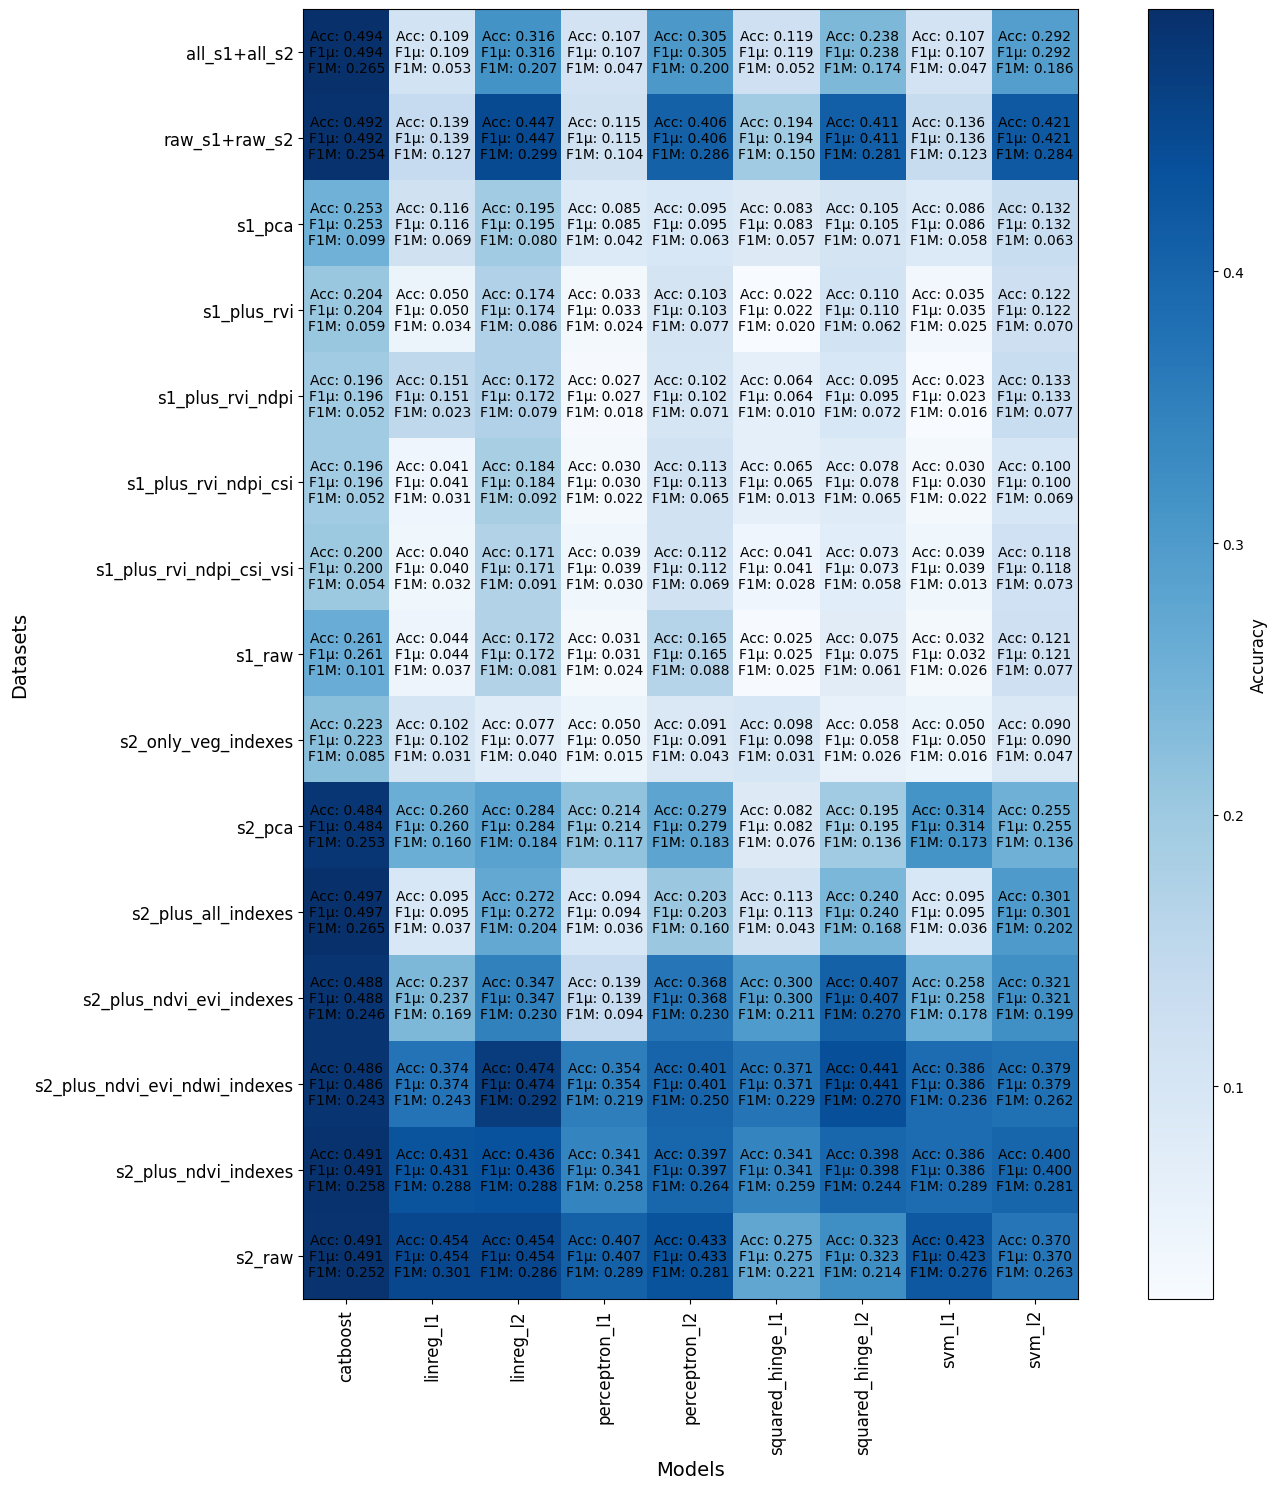

In [33]:
# Extract unique dataset and model names
datasets = sorted(set(key[0] for key in res.keys()))
models = sorted(set(key[1] for key in res.keys()))

# Create a matrix to store accuracy, F1 micro, and F1 macro
matrix = np.empty((len(datasets), len(models)), dtype=object)

# Fill the matrix with res
for (dataset, model), metrics in res.items():
    row = datasets.index(dataset)
    col = models.index(model)
    accuracy, f1_micro, f1_macro, f1_weighted = metrics
    matrix[row, col] = f"Acc: {accuracy:.3f}\nF1µ: {f1_micro:.3f}\nF1M: {f1_macro:.3f}\nF1W: {f1_weighted:.3f}"

# Plot the matrix
fig, ax = plt.subplots(figsize=(15, 15))

# Use a heatmap for visualization
heatmap = np.zeros_like(matrix, dtype=float)  # Placeholder for color intensity
for row in range(len(datasets)):
    for col in range(len(models)):
        heatmap[row, col] = res[(datasets[row], models[col])][0]  # Use accuracy for intensity

im = ax.imshow(heatmap, cmap="Blues")

# Add annotations
for i in range(len(datasets)):
    for j in range(len(models)):
        ax.text(j, i, matrix[i, j], ha="center", va="center", fontsize=10, color="black")

# Set axis labelsst
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(datasets)))
ax.set_xticklabels(models, fontsize=12, rotation=90)
ax.set_yticklabels(datasets, fontsize=12)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Datasets", fontsize=14)

# Add a colorbar to indicate accuracy intensity
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Accuracy", fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
the_best_classifier = CatBoostClassifier(
                    iterations=500,       
                    learning_rate=0.01,   
                    depth=6,              
                    verbose=50,           
                    random_seed=42,       
                    task_type='GPU'
                    )

the_best_classifier.fit(all_datasets['s2_plus_all_indexes'][0], all_datasets['s2_plus_all_indexes'][1])


0:	learn: 2.6786052	total: 112ms	remaining: 55.7s
50:	learn: 2.0614352	total: 2.93s	remaining: 25.8s
100:	learn: 1.8450658	total: 5.81s	remaining: 23s
150:	learn: 1.7300816	total: 8.72s	remaining: 20.2s
200:	learn: 1.6608377	total: 11.6s	remaining: 17.2s
250:	learn: 1.6159246	total: 14.4s	remaining: 14.3s
300:	learn: 1.5840287	total: 17.2s	remaining: 11.4s
350:	learn: 1.5590272	total: 20s	remaining: 8.49s
400:	learn: 1.5393423	total: 22.7s	remaining: 5.6s
450:	learn: 1.5214188	total: 25.4s	remaining: 2.76s
499:	learn: 1.5068749	total: 28.2s	remaining: 0us


In [14]:
best_predictions = the_best_classifier.predict(all_datasets['s2_plus_all_indexes'][2].squeeze())

Validation Accuracy: 49.66%


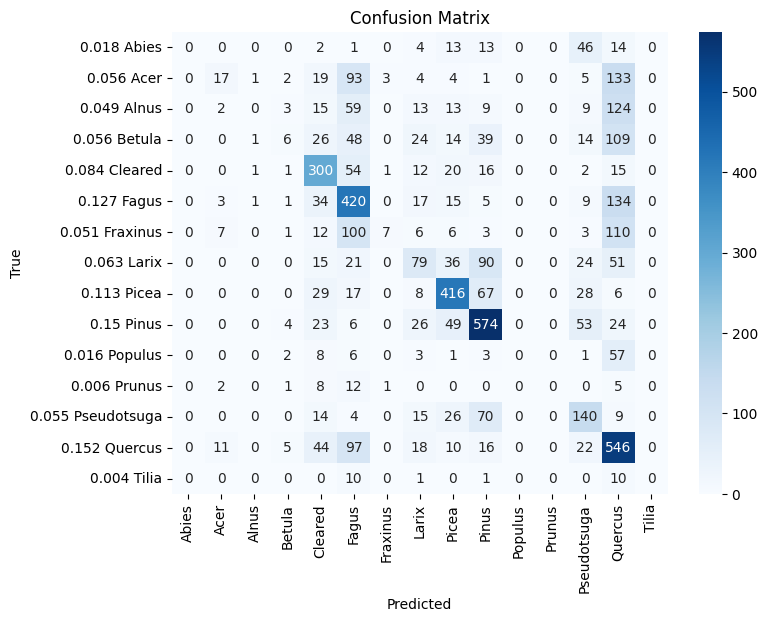

In [15]:
confussion_matrix(all_datasets['s2_plus_all_indexes'][3], best_predictions)

We have to remember that actually every patch contains not only species. Let's explore it deeper:

In [41]:
patch_distros_true = best_predictions.squeeze() == y_val_s2
distros_for_true = full_distrib_val_s2[patch_distros_true].squeeze()
distros_for_false = full_distrib_val_s2[~patch_distros_true].squeeze()


In [76]:
unique_counts_true = np.apply_along_axis(lambda row: len(np.unique(row)), axis=1, arr=distros_for_true)
unique_counts_false = np.apply_along_axis(lambda row: len(np.unique(row)), axis=1, arr=distros_for_false)

We clearly see that the model tends to make mistakes on samples where more than one species is depicted.  
**So, the approach with predicting the most abundant class when the patches also contain a lot of different species / ground is very coarse.**

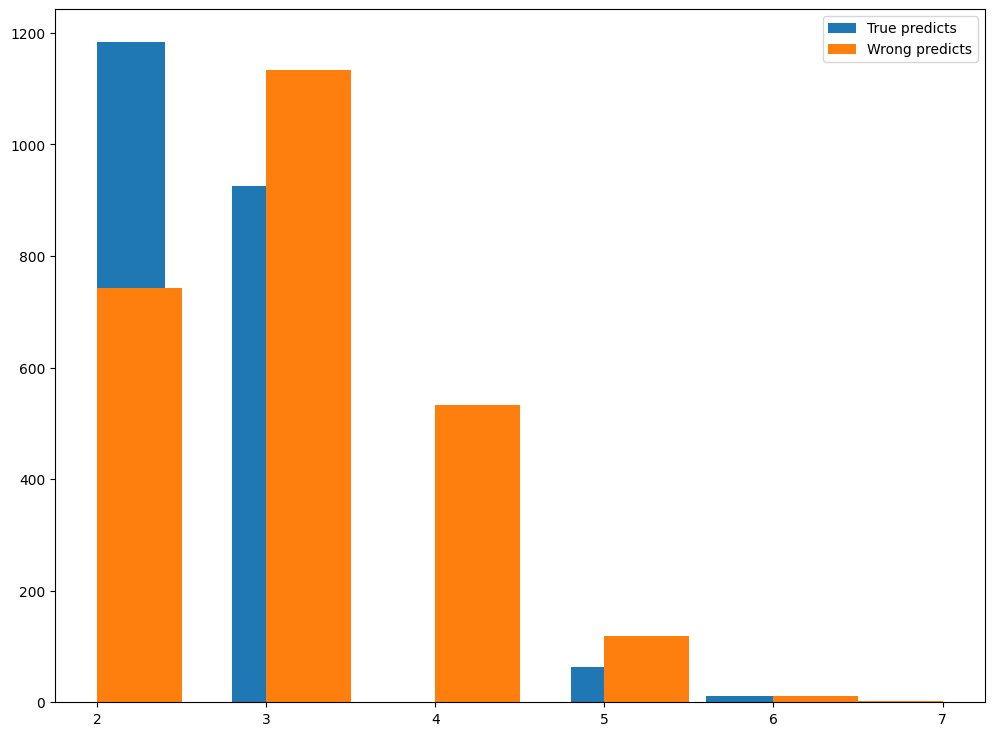

In [ ]:
plt.figure(figsize=(12, 9))

plt.hist(unique_counts_true, label='True predicts')
plt.hist(unique_counts_false, label='Wrong predicts')
plt.legend()

It's not straightforward to set up a multi-regression task (but not the classification of the most abundant species like above) with catboost and other classical ML algorythms so let us try DL methods where the problem may be solved trivially with MSELoss.

But just for lulz let's try optuna to squeeze as much as possible from catboost:

In [12]:
def objective(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "task_type": 'GPU'
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(all_datasets['all_s1+all_s2'][0], all_datasets['all_s1+all_s2'][1])
    predictions = model.predict(all_datasets['all_s1+all_s2'][2])
    accuracy = accuracy_score(all_datasets['all_s1+all_s2'][3], predictions)
    return accuracy

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

[I 2025-02-22 12:19:46,240] A new study created in memory with name: no-name-33ed7893-ef60-4f70-bb1c-a0a3adfdcbf4
[I 2025-02-22 12:20:49,393] Trial 0 finished with value: 0.5267644726407613 and parameters: {'learning_rate': 0.06239851814089989, 'depth': 7, 'min_data_in_leaf': 25}. Best is trial 0 with value: 0.5267644726407613.
[I 2025-02-22 12:21:29,038] Trial 1 finished with value: 0.4831482950039651 and parameters: {'learning_rate': 0.006887326653501027, 'depth': 6, 'min_data_in_leaf': 50}. Best is trial 1 with value: 0.4831482950039651.
[I 2025-02-22 12:21:45,122] Trial 2 finished with value: 0.43180015860428234 and parameters: {'learning_rate': 0.002218771062382765, 'depth': 3, 'min_data_in_leaf': 58}. Best is trial 2 with value: 0.43180015860428234.
[I 2025-02-22 12:21:55,870] Trial 3 finished with value: 0.422680412371134 and parameters: {'learning_rate': 0.007898232701238711, 'depth': 1, 'min_data_in_leaf': 48}. Best is trial 3 with value: 0.422680412371134.
[I 2025-02-22 12:22

So we can squeeze a few hunderts of accuracy from catboost with optuna.

In [ ]:
test = CatBoostClassifier(**study.trials[0].params, iterations=500)


test.fit(all_datasets['all_s1+all_s2'][0], all_datasets['all_s1+all_s2'][1])
predictions = test.predict(all_datasets['all_s1+all_s2'][2])
accuracy = accuracy_score(all_datasets['all_s1+all_s2'][3], predictions)

0:	learn: 2.5325362	total: 1.43s	remaining: 11m 53s
1:	learn: 2.4126420	total: 2.85s	remaining: 11m 49s
2:	learn: 2.3233460	total: 4.29s	remaining: 11m 50s
3:	learn: 2.2496321	total: 5.72s	remaining: 11m 49s
4:	learn: 2.1848837	total: 7.14s	remaining: 11m 46s
5:	learn: 2.1304339	total: 8.53s	remaining: 11m 42s
6:	learn: 2.0845388	total: 9.97s	remaining: 11m 42s
7:	learn: 2.0421119	total: 11.4s	remaining: 11m 42s
8:	learn: 2.0057313	total: 12.8s	remaining: 11m 37s
9:	learn: 1.9739386	total: 14.2s	remaining: 11m 37s
10:	learn: 1.9449435	total: 15.9s	remaining: 11m 44s
11:	learn: 1.9188979	total: 17.4s	remaining: 11m 48s
12:	learn: 1.8937369	total: 18.9s	remaining: 11m 46s
13:	learn: 1.8713425	total: 20.2s	remaining: 11m 41s
14:	learn: 1.8513892	total: 21.8s	remaining: 11m 43s
15:	learn: 1.8326352	total: 23s	remaining: 11m 36s
16:	learn: 1.8147410	total: 24.4s	remaining: 11m 34s
17:	learn: 1.7973877	total: 25.7s	remaining: 11m 29s
18:	learn: 1.7822516	total: 27.1s	remaining: 11m 25s
19:	l

In [ ]:
%%timeit
X_train_ = X_train_s2
(X_train_ - X_train_.mean(axis=(0,2,3), keepdims=True)) / (X_train_.std(axis=(0,2,3), keepdims=True) + 1e-8)

101 ms ± 7.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
X_train_ = torch.from_numpy(X_train_s2).cuda()
(X_train_ - X_train_.mean(axis=(0,2,3), keepdims=True)) / (X_train_.std(axis=(0,2,3), keepdims=True) + 1e-8)

14.6 ms ± 341 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
import torch
X_train_s2_t = torch.from_numpy(X_train_s2)

In [18]:
%%timeit
X_train_s2_t.cuda()

13.6 ms ± 449 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
X_train_s2_t.cuda()

188 ns ± 6.95 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [ ]:
def process_row(row):
    un = np.unique(row)
    if sum(un) != 1.0:
        un[un == 0] = 1 - sum(un)
    return un

un_distros = [process_row(row) for row in full_distrib_train_s1.squeeze()]